In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

# Read in the sample image
#image = mpimg.imread('sample.jpg')
#example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
#grid_img = mpimg.imread(example_grid)
#image = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
#plt.imshow(image)


# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
#rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
#rover_xpos = np.random.random(1)*160 + 20
#rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    # Apply a rotation
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    scale = 10
    # Apply a scaling and a translation
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

def perspect_transform(img):   
    img_size = (img.shape[1], img.shape[0])
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    bottom_offset = 6
    src = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    dst = np.float32([[img_size[0]/2 - dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - 2*dst_size - bottom_offset], 
                      [img_size[0]/2 - dst_size, img_size[1] - 2*dst_size - bottom_offset],
                      ])
       
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)# keep same size as input image
    return warped

#def color_thresh(img, rgb_thresh=(170, 170, 170)):
#    # Create an array of zeros same xy size as img, but single channel
#    color_select = np.zeros_like(img[:,:,0])
#    # Require that each pixel be above all thre threshold values in RGB
#    # above_thresh will now contain a boolean array with "True"
#    # where threshold was met
#    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
#                & (img[:,:,1] > rgb_thresh[1]) \
#                & (img[:,:,2] > rgb_thresh[2])
#    # Index the array of zeros with the boolean array and set to 1
#    color_select[above_thresh] = 1
#    # Return the binary image
#    return color_select

##########################
def color_thresh(img, low_thresh,upper_thresh):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    thresh = ((img[:,:,0] > low_thresh[0]) & (img[:,:,0] < upper_thresh[0]))\
            & ((img[:,:,1] > low_thresh[1]) & (img[:,:,0] < upper_thresh[1])) \
            & ((img[:,:,2] > low_thresh[2]) & (img[:,:,0] < upper_thresh[2]))
    # Index the array of zeros with the boolean array and set to 1
    color_select[thresh] = 1
    xpos= color_select[0]
    # Return the binary image
    return color_select
###########################
    
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Perform warping and color thresholding
warped = perspect_transform(image)
colorsel = color_thresh(warped, low_thresh=(160,160,160),upper_thresh=(255, 255, 255))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
##########
#worldmap = mpimg.imread('map.png')
#plt.imshow(worldmap)
#plt.show()
##############
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)

NameError: name 'rover_xpos' is not defined

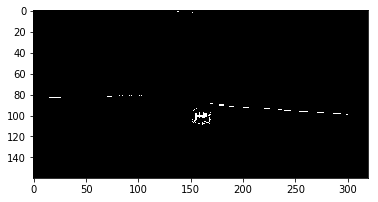

In [12]:
example_rock = '../calibration_images/example_rock2.jpg'
example_rock1 = '../calibration_images/example_rock1.jpg'
#grid_img = mpimg.imread(example_grid)
#image = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)
ob_img = mpimg.imread(example_rock1)


def rocks(img, low_thresh,upper_thresh):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    thresh = ((img[:,:,0] > low_thresh[0]) & (img[:,:,0] < upper_thresh[0]))\
            & ((img[:,:,1] > low_thresh[1]) & (img[:,:,0] < upper_thresh[1])) \
            & ((img[:,:,2] > low_thresh[2]) & (img[:,:,0] < upper_thresh[2]))
    # Index the array of zeros with the boolean array and set to 1
    color_select[thresh] = 1
    xpos= color_select[0]
    # Return the binary image
    return color_select

rock = rocks(ob_img, low_thresh=(140,1,1),upper_thresh=(160, 160, 160))
plt.imshow(rock, cmap='gray')
# rocks==> low_thresh=(130,1,1),upper_thresh=(160, 160, 160)):
# obstacles ==>low_thresh=(1,1,1),upper_thresh=(160, 160, 160))
#warped = perspect_transform(rock_img)
#colorsel = rocks(warped, low_thresh=(130,1,1),upper_thresh=(160, 160, 160))
#plt.imshow(colorsel, cmap='gray')

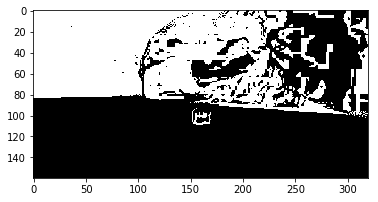

In [13]:
obstacles = rocks(ob_img, low_thresh=(1,1,1),upper_thresh=(160, 160, 160))
plt.imshow(obstacles, cmap='gray')




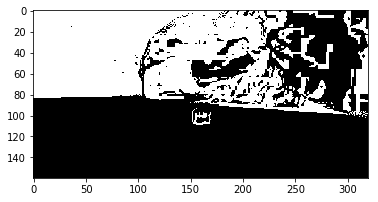

In [14]:
nav = rocks(ob_img, low_thresh=(160,160,160),upper_thresh=(255, 255, 255))
plt.imshow(obstacles, cmap='gray')


In [54]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
df = pd.read_csv('../test_dataset/robot_log.csv')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


In [1]:
# Do the necessary imports
import argparse
import shutil
import base64
from datetime import datetime
import os
import cv2
import numpy as np
import socketio
import eventlet
import eventlet.wsgi
from PIL import Image
from flask import Flask
from io import BytesIO, StringIO
import json
import pickle
import matplotlib.image as mpimg
import time

# Import functions for perception and decision making
from perception import perception_step
from decision import decision_step
from supporting_functions import update_rover, create_output_images
# Initialize socketio server and Flask application 
# (learn more at: https://python-socketio.readthedocs.io/en/latest/)
sio = socketio.Server()
app = Flask(__name__)

# Read in ground truth map and create 3-channel green version for overplotting
# NOTE: images are read in by default with the origin (0, 0) in the upper left
# and y-axis increasing downward.
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
# This next line creates arrays of zeros in the red and blue channels
# and puts the map into the green channel.  This is why the underlying 
# map output looks green in the display image
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Define RoverState() class to retain rover state parameters
class RoverState():
    def __init__(self):
        self.start_time = None # To record the start time of navigation
        self.total_time = None # To record total duration of naviagation
        self.img = None # Current camera image
        self.pos = None # Current position (x, y)
        self.yaw = None # Current yaw angle
        self.pitch = None # Current pitch angle
        self.roll = None # Current roll angle
        self.vel = None # Current velocity
        self.steer = 0 # Current steering angle
        self.throttle = 0 # Current throttle value
        self.brake = 0 # Current brake value
        self.nav_angles = None # Angles of navigable terrain pixels
        self.nav_dists = None # Distances of navigable terrain pixels
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.mode = 'forward' # Current mode (can be forward or stop)
        self.throttle_set = 0.2 # Throttle setting when accelerating
        self.brake_set = 10 # Brake setting when braking
        # The stop_forward and go_forward fields below represent total count
        # of navigable terrain pixels.  This is a very crude form of knowing
        # when you can keep going and when you should stop.  Feel free to
        # get creative in adding new fields or modifying these!
        self.stop_forward = 50 # Threshold to initiate stopping
        self.go_forward = 500 # Threshold to go forward again
        self.max_vel = 2 # Maximum velocity (meters/second)
        # Image output from perception step
        # Update this image to display your intermediate analysis steps
        # on screen in autonomous mode
        self.vision_image = np.zeros((160, 320, 3), dtype=np.float) 
        # Worldmap
        # Update this image with the positions of navigable terrain
        # obstacles and rock samples
        self.worldmap = np.zeros((200, 200, 3), dtype=np.float) 
        self.samples_pos = None # To store the actual sample positions
        self.samples_found = 0 # To count the number of samples found
        self.near_sample = 0 # Will be set to telemetry value data["near_sample"]
        self.picking_up = 0 # Will be set to telemetry value data["picking_up"]
        self.send_pickup = False # Set to True to trigger rock pickup
# Initialize our rover 
Rover = RoverState()
Rover.pos=11,4
print (Rover.pos)
print (Rover.pos[0])
print (Rover.pos[1])
Rover.samples_pos[0]



# Variables to track frames per second (FPS)
# Intitialize frame counter
frame_counter = 0
# Initalize second counter
second_counter = time.time()
fps = None



(11, 4)
11
4


200


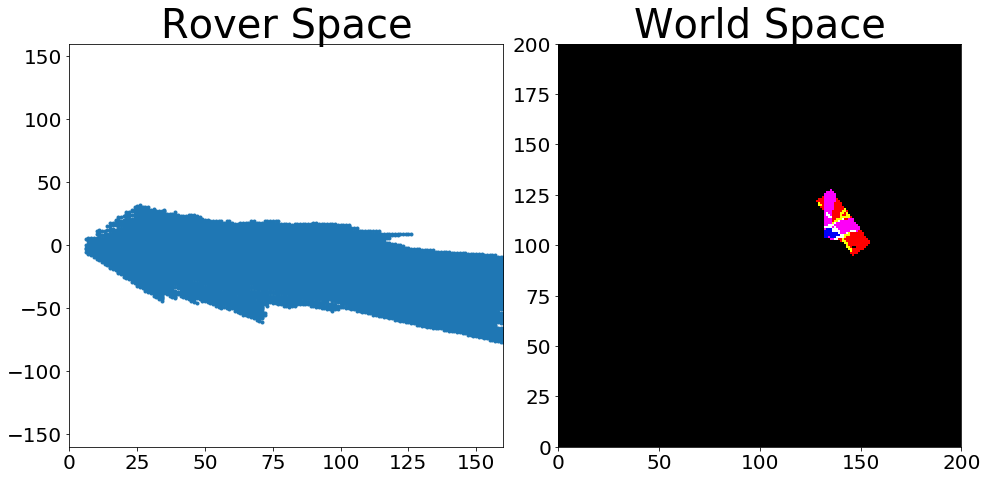

In [131]:
    dist, angles = to_polar_coords(xpix, ypix)

    # 5) Convert rover-centric pixel values to world coords
    #worldmap = np.zeros((200, 200))
    scale = 10
    #rover_xpos = 160
    #rover_ypos = 160
    #rover_yaw = np.random.random(1)*360
    print (data.worldmap.shape[0])
    nav = color_thresh(warped, low_thresh=(160,160,160),upper_thresh=(255, 255, 255))
    # Extract navigable terrain pixels
    xpix, ypix = rover_coords(nav)
    #########
    obstacles = color_thresh(warped, low_thresh=(1,1,1),upper_thresh=(160, 160, 160))
    # Extract navigable terrain pixels
    xpix_ob, ypix_ob = rover_coords(obstacles)
    ob_x, ob_y = pix_to_world(xpix_ob, ypix_ob, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
    data.worldmap[ob_y, ob_x, 0] += 1
    ########
    rock = color_thresh(warped, low_thresh=(140,1,1),upper_thresh=(160, 160, 160))
    xpix_rock, ypix_rock = rover_coords(rock)
    rock_x, rock_y = pix_to_world(xpix_rock, ypix_rock, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
    data.worldmap[rock_y, rock_x, 1] += 1
    ############# nav
    navigable_x_world, navigable_y_world = pix_to_world(xpix, ypix, data.xpos[data.count], 
                                data.ypos[data.count], data.yaw[data.count], 
                                data.worldmap.shape[0], scale)
      # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    #######################################################
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    f.tight_layout()
    ax1.plot(xpix, ypix, '.')
    ax1.set_title('Rover Space', fontsize=40)
    ax1.set_ylim(-160, 160)
    ax1.set_xlim(0, 160)
    ax1.tick_params(labelsize=20)

    ax2.imshow(data.worldmap, cmap='gray')
    ax2.set_title('World Space', fontsize=40)
    ax2.set_ylim(0, 200)
    ax2.tick_params(labelsize=20)
    ax2.set_xlim(0, 200)


    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)


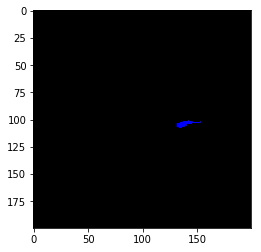

In [52]:
plt.imshow(data.worldmap)